In [7]:
import numpy as np
import pywt
import cv2
import shutil
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Preprocessing

### Testing Image Processing With Cv2

In [9]:
img = cv2.imread(r'dataset\Cristiano_Ronaldo\10017.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape


(500, 400, 3)

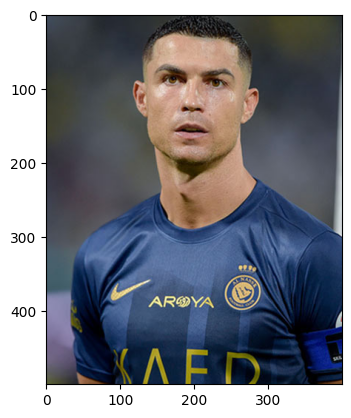

In [10]:
plt.imshow(img)

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(500, 400)

In [12]:
gray

array([[81, 81, 81, ..., 52, 51, 51],
       [81, 81, 81, ..., 52, 52, 51],
       [81, 81, 80, ..., 52, 52, 52],
       ...,
       [89, 87, 85, ..., 77, 82, 85],
       [90, 88, 86, ..., 72, 78, 82],
       [90, 88, 85, ..., 71, 75, 77]], dtype=uint8)

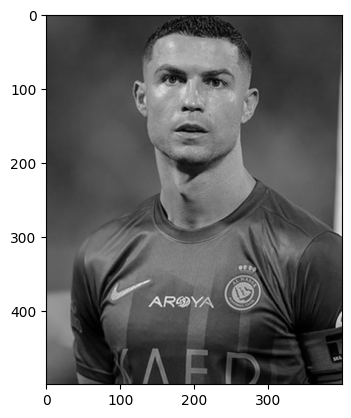

In [13]:
plt.imshow(gray , cmap='gray')

#### Detecting Face & Eyes Using Haarcascades

In [14]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[110,  22, 178, 178]], dtype=int32)

In [15]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(110), np.int32(22), np.int32(178), np.int32(178))

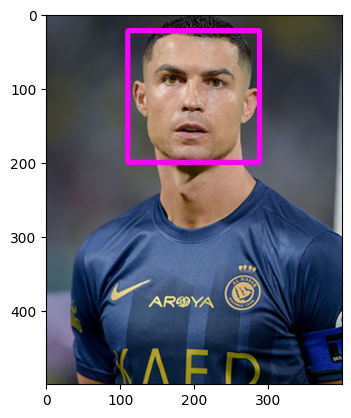

In [16]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 255),5)
plt.imshow(face_img)

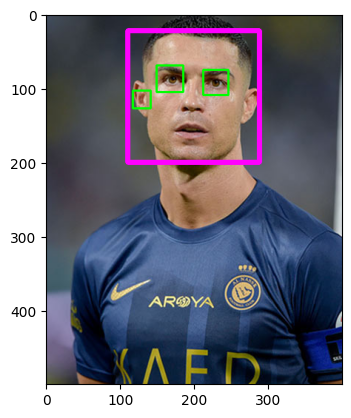

In [17]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

In [ ]:
# Its considering ear as a Eye 
# Such Errors are coommon while using Haarcascades

### Croping the Face from the Images


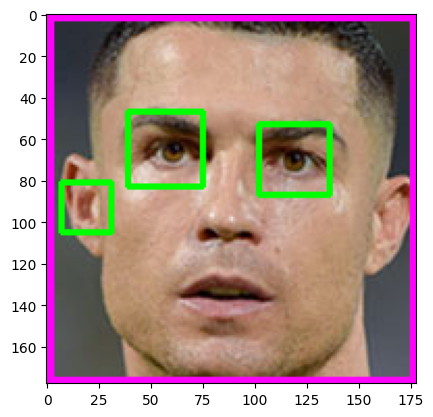

In [18]:
plt.imshow(roi_color, cmap='gray')

In [19]:
cropped_img = np.array(roi_color)
cropped_img.shape

(178, 178, 3)

In [20]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

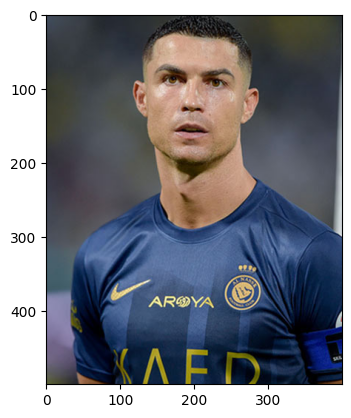

In [23]:
image = cv2.imread(r'dataset\Cristiano_Ronaldo\10017.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

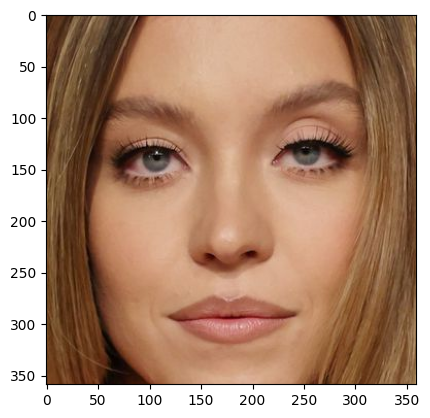

In [24]:
cropped_image = get_cropped_image_if_2_eyes('test_images\Sydney-Sweeny.jpg')
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image)

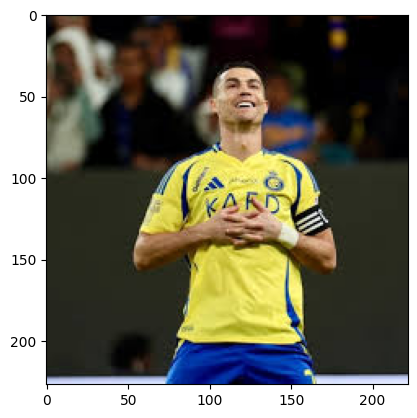

In [25]:
Wrong_image = cv2.imread(r'dataset\Cristiano_Ronaldo\10004.jpg')
Wrong_image = cv2.cvtColor(Wrong_image, cv2.COLOR_BGR2RGB)
plt.imshow(Wrong_image)

In [26]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('test_images\Sydney-Sweeny-Side-pro.jpg')
cropped_image_no_2_eyes 

##### Since No features Were Detected , Above image is not suitable to use to train model so such images will not be used

### Wavelt Transformation For Feature Selrction

In [27]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

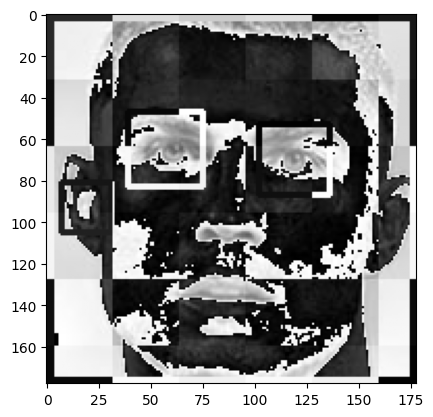

In [28]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [31]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [32]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [33]:
img_dirs

['./dataset/Cristiano_Ronaldo',
 './dataset/cropped',
 './dataset/cropped - Copy',
 './dataset/Kylian Mbappe',
 './dataset/Lamine Yamal',
 './dataset/Lionel  Messi',
 './dataset/Neymar Junior']

In [34]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [35]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        if entry.is_file():  # Only process files
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ", cropped_folder)
                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

Generating cropped images in folder:  ./dataset/cropped/Cristiano_Ronaldo
Generating cropped images in folder:  ./dataset/cropped/Kylian Mbappe
Generating cropped images in folder:  ./dataset/cropped/Lamine Yamal
Generating cropped images in folder:  ./dataset/cropped/Lionel  Messi
Generating cropped images in folder:  ./dataset/cropped/Neymar Junior


In [36]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Cristiano_Ronaldo': ['./dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo1.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo10.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo11.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo12.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo13.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo14.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo15.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo16.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo17.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo18.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo19.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo2.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo20.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo21.png',
  './dataset/cropped/Cristiano_Ronaldo\\Cristiano_Ronaldo

In [37]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Cristiano_Ronaldo': 0,
 'Kylian Mbappe': 1,
 'Lamine Yamal': 2,
 'Lionel  Messi': 3,
 'Neymar Junior': 4}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [38]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [39]:
len(X[0])


4096

In [40]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(106, 4096)

In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7037037037037037

In [43]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.50      1.00      0.67         2
           2       0.80      1.00      0.89         4
           3       0.57      0.57      0.57         7
           4       0.50      0.20      0.29         5

    accuracy                           0.70        27
   macro avg       0.65      0.73      0.66        27
weighted avg       0.69      0.70      0.68        27



In [44]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [45]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [46]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\ZAIN PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZAIN PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZAIN PC\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ZAIN PC\AppData\Roaming\Python\Python310\site-packages\sklearn\l

,model,best_score,best_params
0,svm,0.770833,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.595000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.770833,{'logisticregression__C': 1}


In [47]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [48]:
best_estimators['svm'].score(X_test,y_test)

0.7037037037037037

In [49]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7407407407407407

In [50]:
best_clf = best_estimators['svm']

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[7, 0, 1, 0, 1],
       [0, 2, 0, 0, 0],
       [0, 0, 4, 0, 0],
       [1, 1, 1, 4, 0],
       [0, 0, 0, 3, 2]])

Text(95.72222222222221, 0.5, 'Truth')

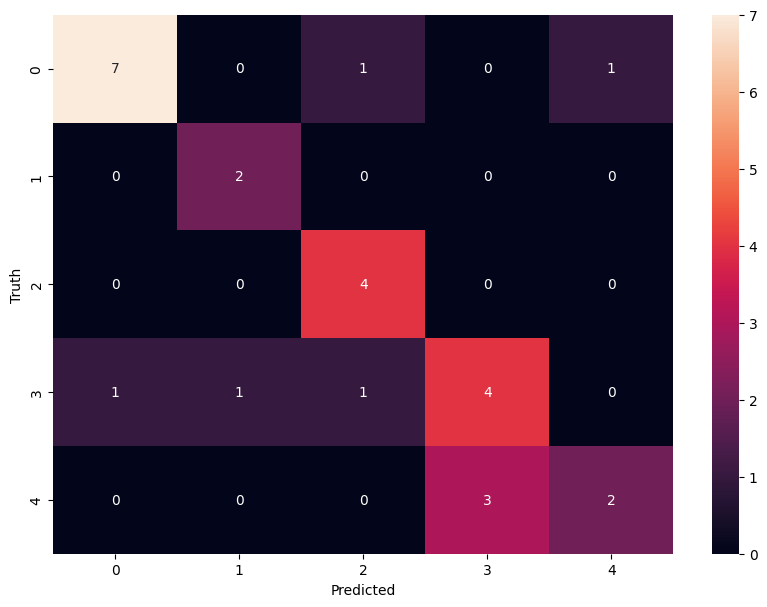

In [52]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [54]:
import os
import pickle

# Ensure the directory exists
os.makedirs('saved_models', exist_ok=True)

# Save the best SVM model
with open('saved_models/best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

print("SVM model saved to 'saved_models/best_svm_model.pkl'")


SVM model saved to 'saved_models/best_svm_model.pkl'
